In [1]:
import ast
import os
import time
import yaml

import matplotlib.pyplot as plt
import pandas as pd
from datasets import load_dataset
from dotenv import load_dotenv
from tqdm import tqdm

from langchain_core.output_parsers import CommaSeparatedListOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from random import shuffle

from dataset_utils import *

config_path = os.path.join("..", "config.yaml")
# Load the configuration file
with open(config_path, "r") as f:
    config = yaml.safe_load(f)
    EMOTIONS, RANDOM_SEED = (
        config["EMOTIONS"],
        config["RANDOM_SEED"],
    )

# Loading Dataset

In [34]:
set_ = "validation"
run_number = 1

In [35]:
dataset = load_dataset("go_emotions", "simplified")
dataset.set_format(type="pandas")
df = dataset[set_][:]
df = df.drop(columns=["id"])

int2label = lambda x: dataset[set_].features["labels"].feature.int2str(x)
df["labels_text"] = df["labels"].apply(int2label)

In [7]:
# samples = df[df["ds_emotions"].apply(lambda x: "neutral" in x)]
# samples = df.sample(200, random_state=RANDOM_SEED)

# Define Model

In [3]:
output_parser = CommaSeparatedListOutputParser()
format_instructions = output_parser.get_format_instructions()

In [4]:
providers_api_base = {
    "ollama": "http://localhost:11434/v1",
    # models in https://fireworks.ai/models
    "fireworks": "https://api.fireworks.ai/inference/v1",
    # models in https://console.groq.com/docs/models
    "groq": "https://api.groq.com/openai/v1",
    # models in https://platform.openai.com/docs/models
    "openai": "https://api.openai.com/v1",
}

In [5]:
model_name = "accounts/fireworks/models/llama-v3-70b-instruct"
provider = "fireworks"
TEMPERATURE = 0.5

# Define models
chat = ChatOpenAI(
    temperature=TEMPERATURE,
    model_name=model_name,
    openai_api_base=providers_api_base[provider],
    openai_api_key=os.environ[provider],
)

# Labeling Functions

In [6]:
import asyncio
import nest_asyncio
from concurrent.futures import ThreadPoolExecutor
from tqdm.asyncio import tqdm

In [7]:
shuffle(EMOTIONS)
SYSTEM_MESSAGE = f"""You're doing a classification task, given each text, think of the emotion it contains and of its context and try to classify it as one of these emotions {EMOTIONS}
"""

PROMPT_TEMPLATE = f"""
List outputs as {format_instructions}
Input: {{comment}}
"""

final_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", SYSTEM_MESSAGE),
        # few_shot_prompt,
        ("human", PROMPT_TEMPLATE),
    ]
)

In [8]:
def process_sample_sync(index, samples, EMOTIONS, format_instructions, chat):
    shuffle(EMOTIONS)
    SYSTEM_MESSAGE = f"""You're doing a classification task, given each text, think of the emotion it contains and of its context and try to classify it as one of these emotions {EMOTIONS}
    """

    PROMPT_TEMPLATE = f"""
    List outputs as {format_instructions}
    Input: {{comment}}
    """

    final_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", SYSTEM_MESSAGE),
            ("human", PROMPT_TEMPLATE),
        ]
    )
    chain = final_prompt | chat
    comment = samples.loc[index]["text"]
    response = chain.invoke(
        {"comment": comment}
    )  # Assuming chain.invoke is synchronous
    content = response.content
    input_tokens = response.response_metadata["token_usage"]["prompt_tokens"]
    output_tokens = response.response_metadata["token_usage"]["completion_tokens"]
    if content is None:
        print(f"Error in index {index}")
    samples.at[index, "predictions"] = content
    return input_tokens, output_tokens

In [17]:
async def generate_predictions(samples, EMOTIONS, format_instructions, chat):
    samples["predictions"] = None
    input_tokens = 0
    output_tokens = 0

    loop = asyncio.get_running_loop()

    with ThreadPoolExecutor() as pool:
        tasks = []
        for index in samples.index:
            try:
                task = loop.run_in_executor(
                    pool,
                    process_sample_sync,
                    index,
                    samples,
                    EMOTIONS,
                    format_instructions,
                    chat,
                )
                tasks.append(task)
            except Exception as e:
                print(f"Error processing sample at index {index}: {e}")
                return None, None, None  # Or any other appropriate return value

        results = await tqdm.gather(*tasks)

    for res in results:
        input_tokens += res[0]
        output_tokens += res[1]

    input_tokens = input_tokens / len(samples)
    output_tokens = output_tokens / len(samples)

    return samples, input_tokens, output_tokens

In [18]:
chunk_size = 500
samples = df.copy()
results_df = pd.DataFrame()  # Initialize an empty DataFrame to store results

for i in range(0, len(df), chunk_size):
    chunk_samples, input_tokens, output_tokens = await generate_predictions(
        samples.iloc[i : i + chunk_size], EMOTIONS, format_instructions, chat
    )
    # Assuming generate_predictions returns a DataFrame or similar structure that can be appended
    results_df = pd.concat([results_df, chunk_samples], ignore_index=True)
    time.sleep(60)

/tmp/ipykernel_1522/2339137956.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples["predictions"] = None
100%|██████████| 500/500 [00:16<00:00, 31.15it/s]
/tmp/ipykernel_1522/2339137956.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples["predictions"] = None
100%|██████████| 500/500 [00:20<00:00, 24.45it/s]
/tmp/ipykernel_1522/2339137956.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



# Labels Postprocessing

In [19]:
def clean_and_parse_predictions(predictions_series):
    result = pd.Series(
        [
            [p.strip() for p in prediction.split(",")]
            for prediction in predictions_series
        ]
    )
    # remove quotes (single, double if any)
    result = result.apply(
        lambda x: [
            item.replace("'", "").replace('"', "").replace("]", "").replace("[", "")
            for item in x
        ]
    )
    # remove and item contains any symbol except quotes
    result = result.apply(lambda x: [item.lower() for item in x if item.isalnum()])

    return result

In [43]:
results_df["predictions"] = clean_and_parse_predictions(results_df["predictions"])

AttributeError: 'list' object has no attribute 'split'

In [56]:
results_df.to_csv(f"run{run_number}/{set_}_unfiltered.csv", index=False)

In [61]:
def filter_predictions(path, EMOTIONS=EMOTIONS):
    """
    Load the predictions from the CSV and filter them to only include the emotions in EMOTIONS
    """
    df = pd.read_csv(path)
    df["parsed_predictions"] = df["predictions"].apply(lambda x: ast.literal_eval(x))
    df["parsed_predictions"] = df["parsed_predictions"].apply(
        lambda x: [label for label in x if label in EMOTIONS]
    )
    # labels is parsed_predictions index
    df["labels"] = df["parsed_predictions"].apply(
        lambda x: [EMOTIONS.index(label) for label in x]
    )
    return df


def visualize_data(df, EMOTIONS=EMOTIONS):
    label_counts = {}
    for labels in df["parsed_predictions"]:
        for label in labels:
            if label in label_counts:
                label_counts[label] += 1
            else:
                label_counts[label] = 1

    filtered_dict = {k: v for k, v in label_counts.items() if k in EMOTIONS}
    sorted_filtered_dict = {
        k: v for k, v in sorted(filtered_dict.items(), key=lambda item: item[1])
    }

    plt.figure(figsize=(10, 8))
    plt.barh(list(sorted_filtered_dict.keys()), list(sorted_filtered_dict.values()))
    plt.show()

    df["count"] = df["parsed_predictions"].apply(lambda x: len(x))
    plt.hist(df["count"], bins=10)
    plt.show()

In [62]:
results_df_filtered = filter_predictions(f"run{run_number}/{set_}_unfiltered.csv")
# visualize_data(results_df_filtered)

In [66]:
results_df_filtered = results_df_filtered.drop(columns=["predictions", "labels_text"])

In [67]:
results_df_filtered.to_csv(f"run{run_number}/{set_}_filtered.csv", index=False)

# Evaluation
Evaluating the correctness of labeling against GT

Results for llama3:8b:
Average BCE Loss: 1.0825
Average F1 Score: 0.2851
Average Precision: 0.3090
Average Recall: 0.3509
Average Distance: 0.2603
Total Distance: 52.0601


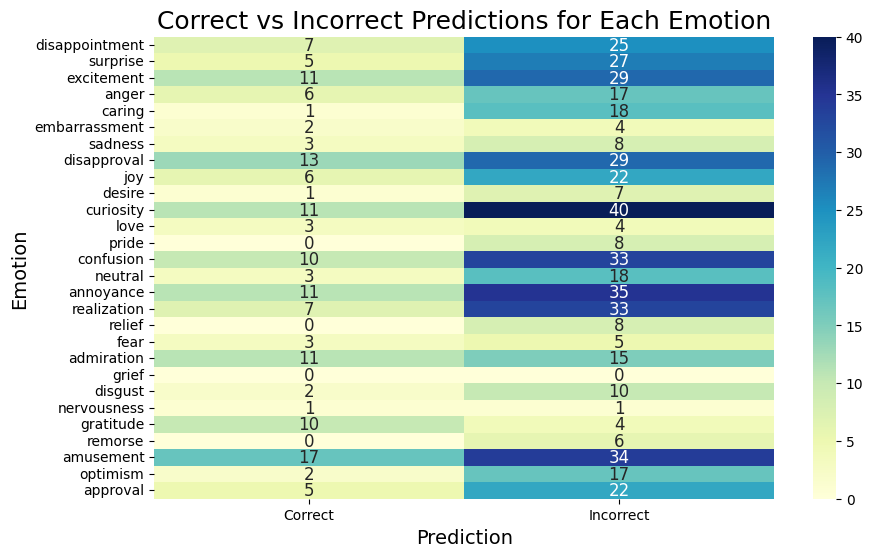

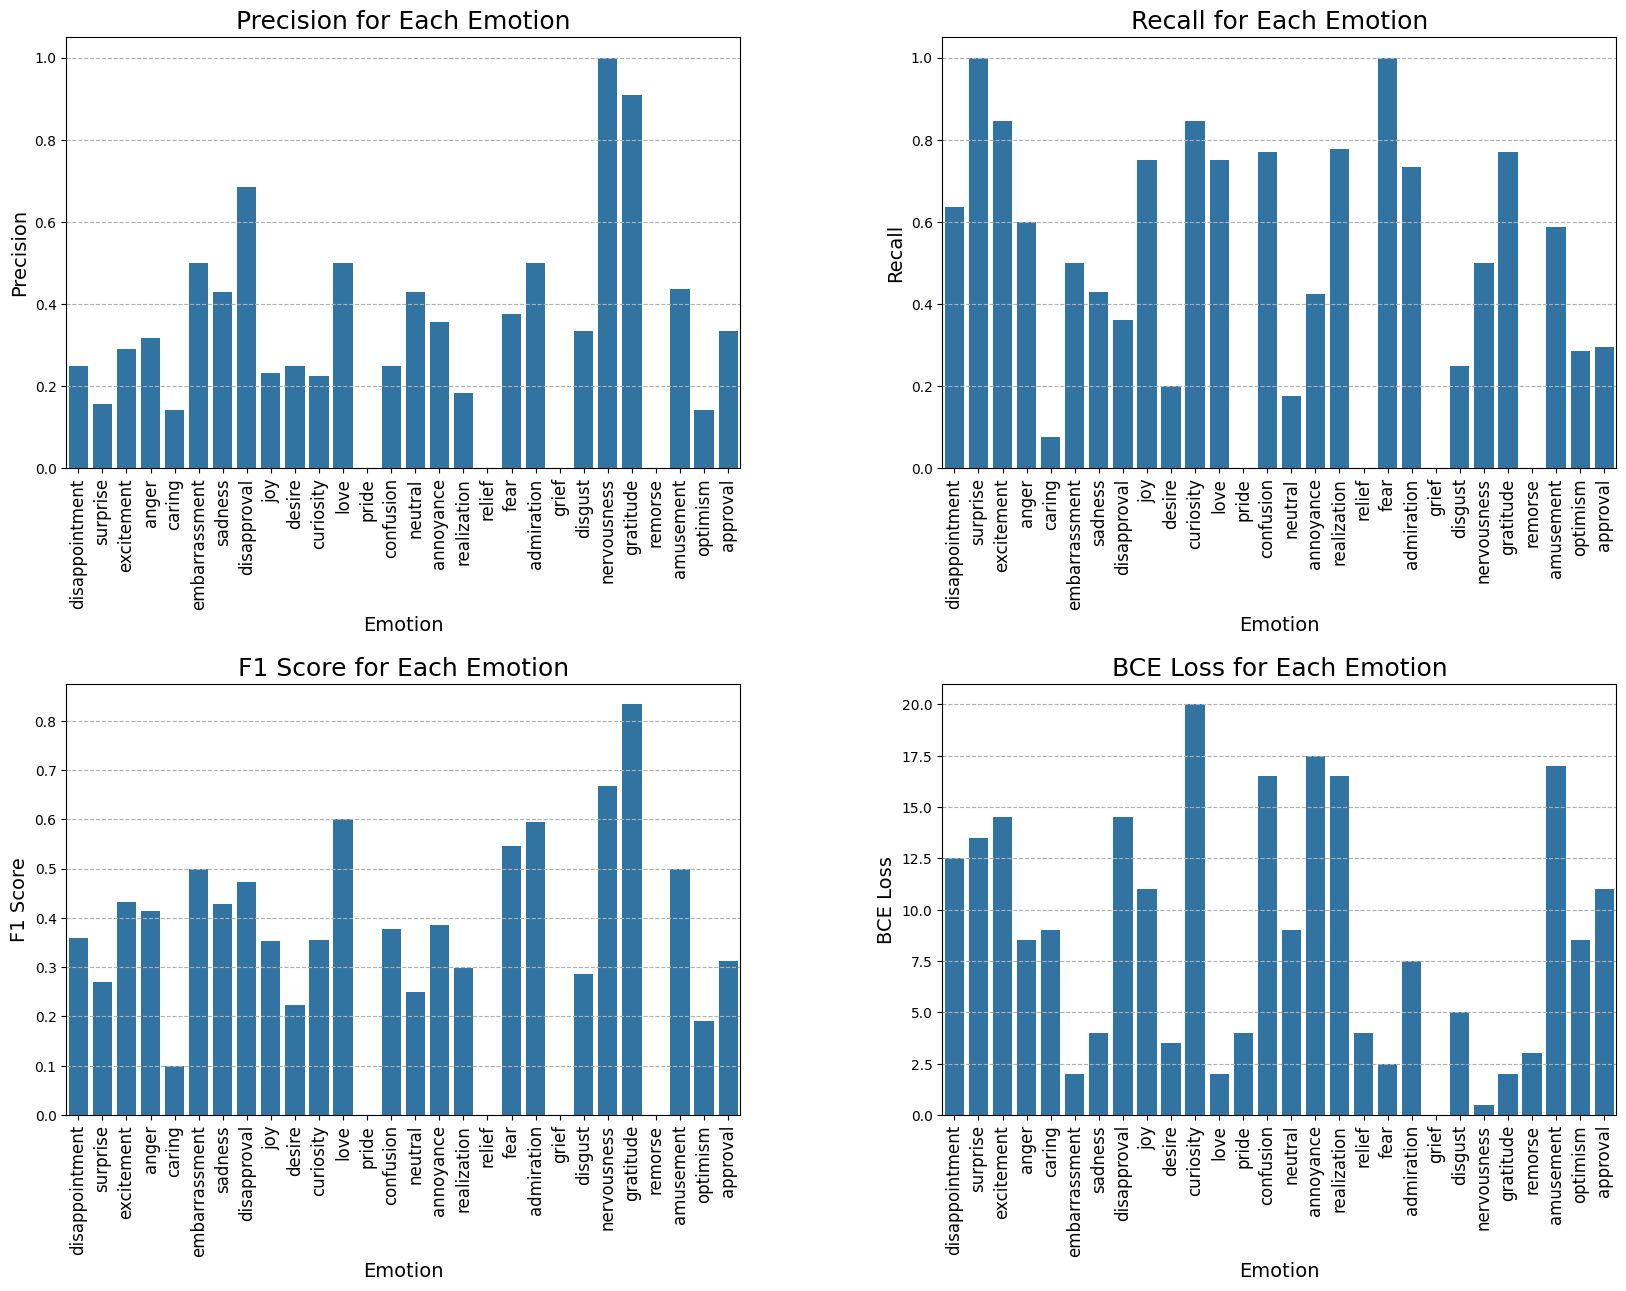

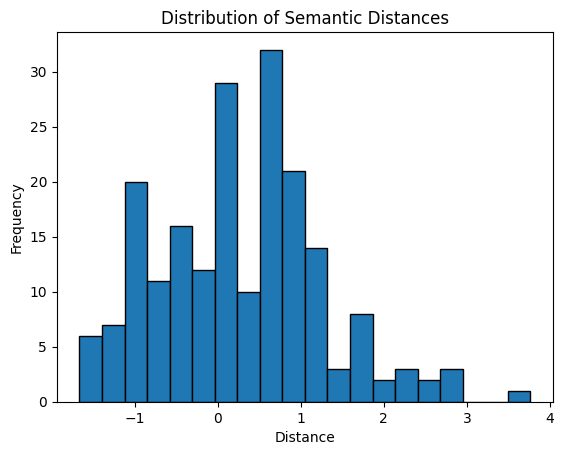

In [ ]:
predicted_labels = clean_and_parse_predictions(samples["predictions"])
ground_truth_labels = pd.read_csv("gt.csv")
ground_truth_labels = ground_truth_labels
ground_truth_labels = ground_truth_labels["ground_truth"]
kwargs = {
    # Default Kwargs
    "provider": provider,
    "temperature": TEMPERATURE,
    "avg_input_tokens": 0,
    "avg_output_tokens": 0,
    # Additional Kwargs
    "ensemble": 1,
}


process_save_results(
    model_name.split("/")[-1],
    SYSTEM_MESSAGE,
    PROMPT_TEMPLATE,
    predicted_labels,
    ground_truth_labels,
    EMOTIONS,
    samples["text"],
    verbose=True,
    ## IMPORTANT ##
    trial_num=6,  # Change this for each trial, visualization will be according to this number
    ################
    **kwargs
)

In [ ]:
# count the total number of correct in the first trail in the json file
with open("results.json", "r") as f:
    results = json.load(f)
    correct = 0
    incorrect = 0
    scores = results[7]["scores"]  # Access the scores part of the JSON
    for emotion, metrics in scores.items():
        if emotion != "average":  # Skip the average key
            correct += metrics["correct"]
            incorrect += metrics["incorrect"]
    print(f"Correct: {correct}")
    print(f"Incorrect: {incorrect}")

Correct: 191
Incorrect: 324


In [ ]:
# count total number of labels in the ground truth csv
total = 0
for label in ground_truth_labels:
    total += len(label.split(","))

print(f"Total: {total}")

Total: 294
